In [29]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import rc

In [30]:
df = pd.read_csv("/home/aemerick/work/gizmo_runs/m10q_30_md_abundances.dat", delim_whitespace=True)

In [28]:

def setup_plots():
    rc('text', usetex=False)
    rc('font', size=17)
    
    return

def weighted_percentile(values, percentiles, weight=None, values_sorted=False):
    """
        As taken from:
        https://stackoverflow.com/questions/21844024/weighted-percentile-using-numpy

        Very close to np.percentile, but supports weights.
        
     NOTE: quantiles should be in [0, 1]!
    :param values: np.array with data
    :param quantiles: array-like with many quantiles needed
    :param weight: array-like of the same length as `array`
    :param values_sorted: bool, if True, then will avoid sorting of initial array
    :return: np.array with computed quantiles.
    """
    values = np.array(values)
    quantiles = np.array(percentiles / 100.0)
    if weight is None:
        weight = np.ones(len(values))
    weight = np.array(weight)
    assert np.all(quantiles >= 0) and np.all(quantiles <= 1), 'quantiles should be in [0, 1]'

    if not values_sorted:
        sorter = np.argsort(values)
        values = values[sorter]
        weight = weight[sorter]

    weighted_quantiles = np.cumsum(weight) - 0.5 * weight
    weighted_quantiles /= np.sum(weight)

    return np.interp(quantiles, weighted_quantiles, values)

def compute_statistics(values, weights=None, limits = [-np.inf, np.inf]):
    """
    Compute a set of statistics for a given set of values with optional
    weights and limits. 
    
    Provide an empty set of values or "None" to see which statistics
    are computed
    
    Parameters
    ----------
    values    : 1D-array
                Array of values to compute. Supply an empty array or 
                'None' to see what statistics are computed.
    weights   : 1D array (optional)
                Optional weights for values. Must be same length as values.
                Default : None
    limits    : list, tuple (optional)
                Minimum and maximum values to consider (2D list, tuple).
                Default considers all values. Default: [-np.inf, np.inf].
                
    Returns:
    --------
    stats     : dictionary
                Dictionary of computed statistics. Provide an empty 'values'
                to see what statistics are computed.
    """
    
    #
    # construct default dictionary. This needs to be updated if
    # new stats are computed below.
    #
    stats = {'limits' : [], 
             'number' : 0, 
             'median' : 0, 
             'mean' : 0,
             '1-sigma' : 0, 
             '2-sigma' : 0, 
             '3-sigma' : 0,
             '1-sigma_range' : 0, 
             '2-sigma_range' : 0, 
             '3-sigma_range' : 0,
             'IQR' : 0, 'inter_quartile_range' : 0, 
             'inter_decile_range' : 0,
             'mean_median_diff' : 0,
             'variance' : 0,
             'std': 0, 
             'min' : 0, 
             'max' : 0}
    #
    # percentiles to compute, with string formatter 
    # to eliminate trailing zeros and decimals in percentile
    #
    # e.g. percentile_0.135  and percentile_10
    #
    percentiles_list = [0.135, 2.275, 10, 15.865, 25, 50, 75, 84.135, 90, 97.725, 99.865]
    perc_string = lambda x : ("%.3f"%(x)).rstrip("0").rstrip('.')
    for pval in percentiles_list:
        stats['percent_' + perc_string(pval)] = 0
        
    # some shorthand percentiles for the 1,2,3 sigma percentiles
    for k in ['0.1','2','16','84','98','99']:
        stats['percent_' + k] = 0

    
    # don't throw an error if values is empty
    # just return an empty stats dictionary
    if values is None or len(values) == 0:
        return stats
    
    #
    # Now actually compute the statistics
    #
    
    # select out based on limits
    mask = (values >= limits[0] ) * (values < limits[-1])
    _values = values[mask]
    
    nvalues = np.size(_values)
    if weights is None:
        _weights = np.ones(nvalues)
    else:
        
        if len(weights) != len(mask):
            print("Weights must have same size (%i) as `values` array (%i)"%(np.size(weights),np.size(values)))
            raise ValueError
            
        _weights = weights[mask]
    
    stats['limits'] = limits
    stats['number'] = nvalues

        
    stats['mean']      = np.average(_values, weights=_weights)
    stats['variance']  = np.sum(weights/np.sum(weights) * (_values - stats['mean'])**2)
    stats['std']       = np.sqrt(stats['variance'])
    
    for pval in percentiles_list:
        stats['percent_' + perc_string(pval)] =\
                                  weighted_percentile(_values,pval,_weights)
        
    stats['median'] = stats['percent_50']
    
    # copy relevant percentiles into 1, 2, and 3 sigma interval pairs
    stats['1-sigma'] = [stats['percent_15.865'], stats['percent_84.135']]
    stats['2-sigma'] = [stats['percent_2.275'] , stats['percent_97.725']]
    stats['3-sigma'] = [stats['percent_0.135'] , stats['percent_99.865']]
    
    # and make some shorthand percentiles for these
    for k1, k2 in [ ('16','15.865'), ('84','84.135'),('2','2.275'),('98','97.725'),('0.1','0.135'),('99','99.865')]:
        stats['percent_'+k1] = stats['percent_' + k2]    
    
    #
    # derived statistics giving ranges
    #
    for k in ['1-sigma','2-sigma','3-sigma']:
        stats[k + '_range'] = stats[k][1] - stats[k][0]
    stats['IQR']                  = stats['percent_75'] - stats['percent_25']
    stats['inter_quartile_range'] = stats['IQR']
    stats['inter_decile_range']   = stats['percent_90'] - stats['percent_10']
    stats['mean_median_diff']     = stats['mean'] - stats['median']
    
    # min, max
    stats['min'] = np.min(_values)
    stats['max'] = np.max(_values)
        
    
    return stats

def binned_statistics(values_x, values_y, limits = None, nbins = 100,
                      bins = None, weights = None,
                      y_limits = [-np.inf, np.inf],
                      empty_value = np.nan,
                      return_binned_values = False):
    """
    Computes binned statistics of `values_y` as a function of `values_x` with optional
    weights. 
    
    Parameters :
    -------------
    values_x, values_y : 1D array
            1D arrays of same length to compute statistics on. Bins `values_y` as 
            a function of `values_x`. 
            
    limits : list, tuple, optional
            Min and max values in x dimension to bin along. If not provided,
            defaults to min and max values of `values_x`. 
            Ignored if `bins` provided. Default : None
            
    nbins   : int, optional
            Number of bins. Ignored if `bins` provided. Default : 100
            
    bins    : 1D array, optional
            Bins in `values_x` to use. Overrides `limits` and `nbins` arguements.
            Default : None
            
    weights : 1D array, optional
            Weights to use when computing statistics. Must be same size as 
            `values_x`. Default : None
            
    y_limits : list, tuple, optional
            Limits for `values_y` below / above which these values will be
            ignored. Default is to accept all `values_y`. Default : [-np.inf,np.inf]
            
    empty_value : optional
             If a bin is empty, stats for that bin (except `number`)
             are set to this value. Default is `np.nan` to mask out 
             when plotting.
            
    return_binned_values : bool, optional
            Return a list of the `values_y` in each bin as well in the 
            output dictionary. Default : False.
    
    Returns:
    ---------
    binned_stats : dict
                   Dictionary containing binned statistics for 
                   `values_y` as a function of `values_x`, and some
                   summary statistics about the data and bins. 
                   Most values will be 1D arrays. 
    """
    
    if bins is None:
        if limits is None:
            limits = [np.min(values_x), np.max(values_x)]
        bins = np.linspace(limits[0], limits[-1], nbins+1)      
    else:
        limits = [bins[0], bins[-1]]
        nbins  = np.size(bins)
    

    mask = (values_x >= limits[0]) * (values_x < limits[-1])
    _values_x = values_x[mask]
    _values_y = values_y[mask]
    
    if weights is None:
        _weights = np.ones(np.size(_values_x))
    else:
        _weights = weights[mask]
        
    # get kwargs of statistics that will be computed
    # to build dictionary of lists to house the binned stats
    empty_stats = compute_statistics(None)
    
    binned_stats = {'bins'        : bins,      # bin edges
                    'lbins'       : bins[:-1], # left bin edges
                    'rbins'       : bins[1:],  # right bin edges
                    'bins_mid'    : 0.5*(bins[:-1]+bins[1:]), # bin centers
                    'bins_diff'   : (bins[1:]-bins[:-1]),     # db
                    'bin_limits'  : limits,  
                    'y_limits'    : y_limits,
                    'total_number': np.size(_values_x),
                    'binned_y'    : [],    # empty for now, optional to generate
                    'nbins'       : nbins}
    
    #
    # initialize the statistics (better than appending to a list)
    #
    
    # stats to skip and not save in binned statistic.
    # these are all lists / tuples and redundant with other
    # information
    skip_stats = ['limits','1-sigma','2-sigma','3-sigma'] 
        
    for k in empty_stats.keys():
        if k in skip_stats:
            continue
        binned_stats[k] = np.zeros(binned_stats['nbins']-1)
        
    if return_binned_values:
        binned_stats['binned_y'] = [None] * binned_stats['nbins']
    
    #
    # generate the masks for all of the points
    #
    bin_indexes = np.digitize(_values_x, bins, right = False)
    #print(binned_stats['nbins'],np.min(bin_indexes),np.max(bin_indexes))
    for i in np.arange(binned_stats['nbins']-1):
        #
        # Generate mask and get y values in this bin
        #
        mask     = bin_indexes == i
        masked_y = _values_y[mask]
        
        #
        # compute and save all stats for this bin.
        #
        stats = compute_statistics(masked_y, weights = _weights[mask],
                                   limits = y_limits)
        
        if stats['number'] == 0:
            #
            # Set the stats to the empty value
            # (by default, np.nan to mask out when plotting)
            #
            for k in stats.keys():
                if k in skip_stats:
                    continue
                binned_stats[k][i] = empty_value
            binned_stats['number'][i] = 0
            
        else:
            # save all stats (except the skipped ones)
            for k in stats.keys():
                if k in skip_stats:
                    continue
                # print(i,k,stats[k])
                binned_stats[k][i] = stats[k]
        
        # save masked y values if requested
        if return_binned_values:
            binned_stats['binned_y'][i] = masked_y
    
    
    return binned_stats

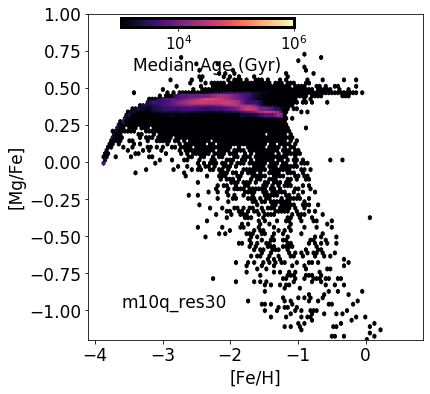

In [31]:
def weighted_median(vals_array):
    """
    Take in a list / array of vals where we assume each element
    has two numbers :  [(1,2), (3,4)....] etc. where
    the first value is the value of interest and the second
    is the weighting.
    
    Returns the weighted median for the values
    """
    
    weight = np.array([_x[0] for _x in vals_array])
    val    = np.array([_x[1] for _x in vals_array])
    
    return weighted_percentile(val, 50.0, weight=weight)

# make sure rc settings are ON
setup_plots()


nrow = 1
ncol = 3
fs   = 6

#
#
# Plot a canonical plot of stellar abundance information
# for these datasets, comparing the abundance of 
# magnesium and iron in stars, colored by their median age
#
nrow, ncol = 1, 1
fig,ax = plt.subplots(nrow,ncol,sharex=True,sharey=True)
fig.set_size_inches(ncol*fs,nrow*fs)
fig.subplots_adjust(wspace=0,hspace=0)

axi=axj=0

C = [c for c in zip(df.mass.values, df.age.values)]
im=ax.hexbin(df.fe_over_h.values,
                 df.mg_over_fe.values,
                 C = df.mass.values,
                 reduce_C_function = np.sum,
                 #C = C,                             # values to pass to reduction function
                 #reduce_C_function=weighted_median, # reduction function
                 bins = 'log',
                 vmin = 1.0E3, 
                 vmax = 1.0E6,
                 gridsize=100,               
                 cmap='magma')
if axj == 0:
    im1 = im
    
xy = (0.1,0.1)
ax.annotate('m10q_res30', xy=xy,xytext=xy,xycoords='axes fraction')

ax.set_ylabel(r'[Mg/Fe]')
ax.set_xlabel(r'[Fe/H]')
ax.set_ylim(-1.2,1.0)
    

#
# Place the colorbar nicely and label
#
left = 0.2
upper = 0.85
cb_ax = fig.add_axes([left,upper,0.4,0.02])
cbar = fig.colorbar(im1, cax=cb_ax,orientation='horizontal')        
cbar.outline.set_edgecolor('black')
cbar.outline.set_linewidth(3)
cbar.ax.tick_params(axis='both', colors='black',labelsize=15) #,weight='bold') 
cbar.set_label("Median Age (Gyr)")
#plt.tight_layout()
plt.show()

plt.close()


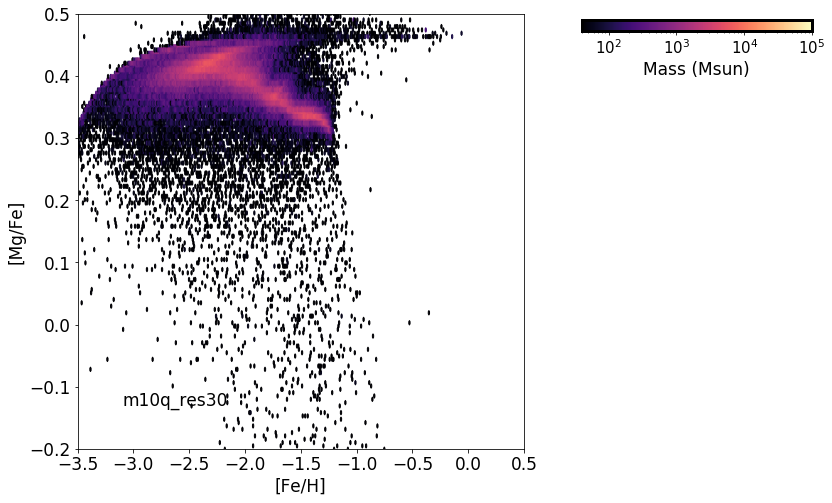

In [32]:
def weighted_median(vals_array):
    """
    Take in a list / array of vals where we assume each element
    has two numbers :  [(1,2), (3,4)....] etc. where
    the first value is the value of interest and the second
    is the weighting.
    
    Returns the weighted median for the values
    """
    
    weight = np.array([_x[0] for _x in vals_array])
    val    = np.array([_x[1] for _x in vals_array])
    
    return weighted_percentile(val, 50.0, weight=weight)

# make sure rc settings are ON
setup_plots()


nrow = 1
ncol = 1
fs   = 8

#
#
# Plot a canonical plot of stellar abundance information
# for these datasets, comparing the abundance of 
# magnesium and iron in stars, colored by their median age
#
nrow, ncol = 1, 1
fig,ax = plt.subplots(nrow,ncol,sharex=True,sharey=True)
fig.set_size_inches(ncol*fs,nrow*fs)
fig.subplots_adjust(wspace=0,hspace=0)

axi=axj=0

C = [c for c in zip(df.mass.values, df.age.values)]
im=ax.hexbin(df.fe_over_h.values,
                 df.mg_over_fe.values,
                 C = df.mass.values,
                 reduce_C_function = np.sum,
                 #C = C,                             # values to pass to reduction function
                 #reduce_C_function=weighted_median, # reduction function
                 bins = 'log',
                 vmin = 40.0, 
                 vmax = 1.0E5,
                 gridsize=400,               
                 cmap='magma')
if axj == 0:
    im1 = im
    
xy = (0.1,0.1)
ax.annotate('m10q_res30', xy=xy,xytext=xy,xycoords='axes fraction')

ax.set_ylabel(r'[Mg/Fe]')
ax.set_xlabel(r'[Fe/H]')
ax.set_ylim(-.2,0.5)
ax.set_xlim(-3.5,0.5)
    

#
# Place the colorbar nicely and label
#
left = 1.0
upper = 0.85
cb_ax = fig.add_axes([left,upper,0.4,0.02])
cbar = fig.colorbar(im1, cax=cb_ax,orientation='horizontal')        
cbar.outline.set_edgecolor('black')
cbar.outline.set_linewidth(3)
cbar.ax.tick_params(axis='both', colors='black',labelsize=15) #,weight='bold') 
cbar.set_label("Mass (Msun)")
#plt.tight_layout()

plt.show()

plt.close()


(-0.2, 0.5)

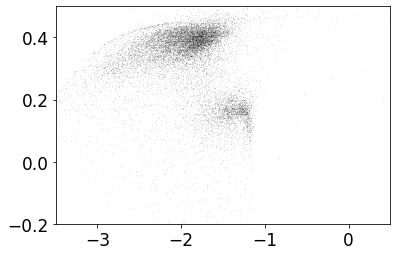

In [25]:
plt.scatter(df.mg_over_h.values, df.mg_over_fe.values, s=0.001, color = 'black')
plt.xlim(-3.5,0.5)
plt.ylim(-0.2,0.5)

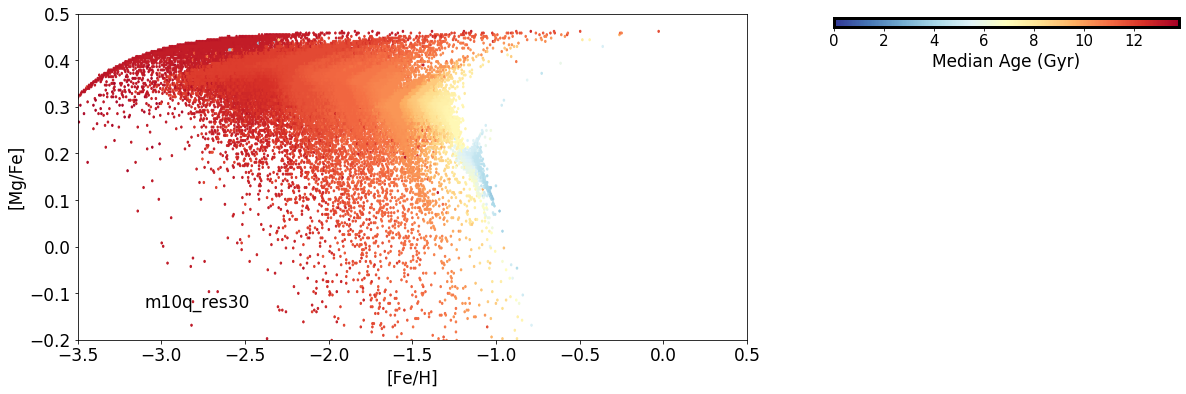

In [38]:
def weighted_median(vals_array):
    """
    Take in a list / array of vals where we assume each element
    has two numbers :  [(1,2), (3,4)....] etc. where
    the first value is the value of interest and the second
    is the weighting.
    
    Returns the weighted median for the values
    """
    
    weight = np.array([_x[0] for _x in vals_array])
    val    = np.array([_x[1] for _x in vals_array])
    
    return weighted_percentile(val, 50.0, weight=weight)

# make sure rc settings are ON
setup_plots()


nrow = 1
ncol = 3
fs   = 6

#
#
# Plot a canonical plot of stellar abundance information
# for these datasets, comparing the abundance of 
# magnesium and iron in stars, colored by their median age
#
nrow, ncol = 1, 1
fig,ax = plt.subplots(nrow,ncol,sharex=True,sharey=True)
fig.set_size_inches(ncol*fs*2,nrow*fs)
fig.subplots_adjust(wspace=0,hspace=0)

axi=axj=0

C = [c for c in zip(df.mass.values, df.age.values)]
im=ax.hexbin(df.fe_over_h.values,
                 df.mg_over_fe.values,
                 #C = df.mass.values,
                 #reduce_C_function = np.sum,
                 C = C,                             # values to pass to reduction function
                 reduce_C_function=weighted_median, # reduction function
                 #bins = 'log',
                 vmin = 0.0,
                 vmax = 13.8,
                 gridsize=500,               
                 cmap='RdYlBu_r')
if axj == 0:
    im1 = im
    
xy = (0.1,0.1)
ax.annotate('m10q_res30', xy=xy,xytext=xy,xycoords='axes fraction')

ax.set_ylabel(r'[Mg/Fe]')
ax.set_xlabel(r'[Fe/H]')
#ax.set_ylim(-1.2,1.0)
ax.set_ylim(-.2,0.5)
ax.set_xlim(-3.5,0.5)
        

#
# Place the colorbar nicely and label
#
left = 1.
upper = 0.85
cb_ax = fig.add_axes([left,upper,0.4,0.02])
cbar = fig.colorbar(im1, cax=cb_ax,orientation='horizontal')        
cbar.outline.set_edgecolor('black')
cbar.outline.set_linewidth(3)
cbar.ax.tick_params(axis='both', colors='black',labelsize=15) #,weight='bold') 
cbar.set_label("Median Age (Gyr)")
#plt.tight_layout()
plt.show()

plt.close()


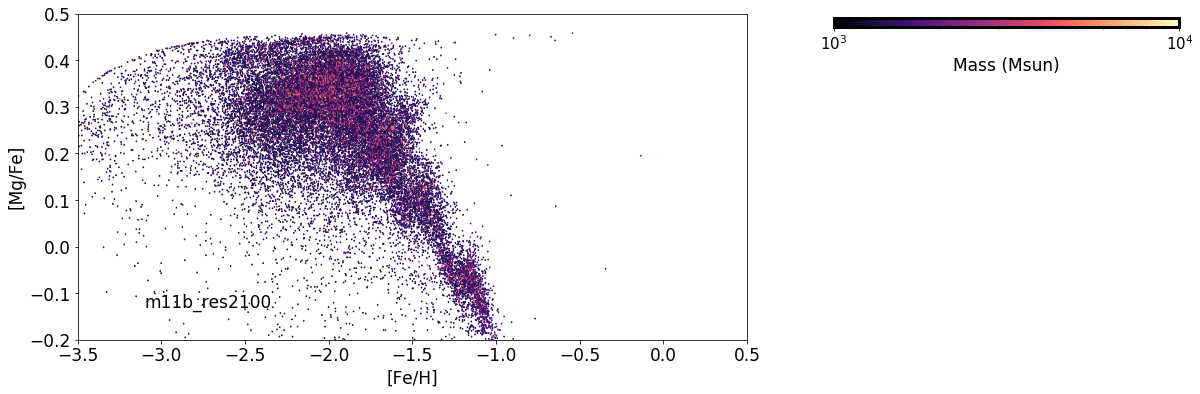

In [10]:
def weighted_median(vals_array):
    """
    Take in a list / array of vals where we assume each element
    has two numbers :  [(1,2), (3,4)....] etc. where
    the first value is the value of interest and the second
    is the weighting.
    
    Returns the weighted median for the values
    """
    
    weight = np.array([_x[0] for _x in vals_array])
    val    = np.array([_x[1] for _x in vals_array])
    
    return weighted_percentile(val, 50.0, weight=weight)

# make sure rc settings are ON
setup_plots()


nrow = 1
ncol = 1
fs   = 6

#
#
# Plot a canonical plot of stellar abundance information
# for these datasets, comparing the abundance of 
# magnesium and iron in stars, colored by their median age
#
nrow, ncol = 1, 1
fig,ax = plt.subplots(nrow,ncol,sharex=True,sharey=True)
fig.set_size_inches(ncol*fs*2,nrow*fs)
fig.subplots_adjust(wspace=0,hspace=0)

axi=axj=0

C = [c for c in zip(df.mass.values, df.age.values)]
im=ax.hexbin(df.fe_over_h.values,
                 df.mg_over_fe.values,
                 C = df.mass.values,
                 reduce_C_function = np.sum,
                 #C = C,                             # values to pass to reduction function
                 #reduce_C_function=weighted_median, # reduction function
                 bins = 'log',
                 vmin = 1000.0, 
                 vmax = 1.0E4,
                 gridsize=1000,               
                 cmap='magma')
if axj == 0:
    im1 = im
    
xy = (0.1,0.1)
ax.annotate('m11b_res2100', xy=xy,xytext=xy,xycoords='axes fraction')

ax.set_ylabel(r'[Mg/Fe]')
ax.set_xlabel(r'[Fe/H]')
ax.set_ylim(-.2,0.5)
ax.set_xlim(-3.5,0.5)
    

#
# Place the colorbar nicely and label
#
left = 1.0
upper = 0.85
cb_ax = fig.add_axes([left,upper,0.4,0.02])
cbar = fig.colorbar(im1, cax=cb_ax,orientation='horizontal')        
cbar.outline.set_edgecolor('black')
cbar.outline.set_linewidth(3)
cbar.ax.tick_params(axis='both', colors='black',labelsize=15) #,weight='bold') 
cbar.set_label("Mass (Msun)")
#plt.tight_layout()

plt.show()

plt.close()


In [ ]:

# ----------------------------------------------------------------------------------------
#
# Make a second plot showing more details of the particular distributions
#
# 1) [Mg/Fe] vs. [Fe/H]
# 2) [Fe/H] PDF
# 3  [Mg/Fe] PDF
#

fig,all_ax = plt.subplots(nrow,ncol)
fig.set_size_inches(ncol*fs,nrow*fs)
        
#
# Compare all 3 datasets using running medians
# and 1 and 3 sigma shading around the median
#
for i,name in enumerate(all_df.keys()):

    # compute statistics of mg / iron 
    # as a function of iron
    stats = binned_statistics(all_df[name].fe_over_h.values, all_df[name].mg_over_fe.values,
                              bins=np.arange(-4,1.01,0.1), weights = all_df[name].mass.values)
    
    color = 'C%i'%(i)
    # plot the median
    all_ax[0].plot(stats['bins_mid'], stats['median'], lw = 3, color = color,
                   label = name, ls = '-')
    
    # shade in scatter around median
    all_ax[0].fill_between(stats['bins_mid'], stats['percent_16'], stats['percent_84'],
                           color = color, alpha = 0.5)
    all_ax[0].fill_between(stats['bins_mid'], stats['percent_0.1'], stats['percent_99'],
                           color = color, alpha = 0.25)    
    
    # use the binned statistics results to plot the iron histogram
    all_ax[1].step(stats['bins_mid'], stats['number']/(1.0*np.sum(1.0*stats['number'])) / stats['bins_diff'], lw = 3, where='mid')
    
    # bin the magnesium over iron data and plot
    hist,bins = np.histogram(all_df[name].mg_over_fe, bins = np.arange(-1.5,1.51,0.05))
    all_ax[2].step(0.5*(bins[1:]+bins[:-1]), hist/(1.0*np.sum(hist)) / (bins[1:]-bins[:-1]), lw = 3, where = 'mid')
  
#
# Handle all of the plot axes limits and labelling
#
all_ax[0].legend(loc='lower left')

all_ax[0].set_xlabel(r'log$_{10}$( Iron Abund. )')
all_ax[1].set_xlabel(r'log$_{10}$( Iron Abund. )')
all_ax[2].set_xlabel(r'log$_{10}$( Magnesium / Iron Abund.)')

all_ax[0].set_ylim(-1.25,1.0)
all_ax[1].set_ylim(1.0E-4,10)
all_ax[2].set_ylim(1.0E-4,10)

all_ax[1].semilogy()
all_ax[2].semilogy()

all_ax[0].set_ylabel(r'log$_{10}$( Magnesium / Iron Abund.)')
all_ax[1].set_ylabel(r'Iron Abundance PDF')
all_ax[2].set_ylabel(r'Magnesium / Iron PDF')

plt.tight_layout()